Section 1: Introduction

## Implementing Multi-Head Attention in Flax
In this notebook, we’ll explore **multi-head attention**, a powerful mechanism in transformer models that allows the model to focus on different parts of an input sequence simultaneously. Building on the concept of self-attention, multi-head attention enhances flexibility and expressiveness.

By the end of this notebook, you’ll:
- Understand the purpose and benefits of multi-head attention.
- Implement it using Flax and JAX.
- Visualize attention weights to see how different heads work.

Section 2: Theory

### Theory of Multi-Head Attention
Multi-head attention runs several attention mechanisms (heads) in parallel, each with its own set of query (Q), key (K), and value (V) projections. The outputs are concatenated and linearly transformed to produce the final result.

The mathematical formulation is:

**MultiHead(Q, K, V) = Concat(head_1, ..., head_h) W^O**

Where each **head_i = Attention(Q W_i^Q, K W_i^K, V W_i^V)**, and:
- **W_i^Q, W_i^K, W_i^V**: Projection matrices for each head.
- **W^O**: Final output projection matrix.

This approach allows the model to capture diverse relationships in the data.

Section 3: Implementation

### Implementing Multi-Head Attention in Flax
We’ll create a `MultiHeadAttention` module in Flax, which splits the input into multiple heads, computes attention, and combines the results.

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn

class MultiHeadAttention(nn.Module):
    embed_dim: int  # Dimension of input embeddings
    num_heads: int  # Number of attention heads
    head_dim: int   # Dimension per head

    def setup(self):
        # Projections for Q, K, V
        self.query = nn.Dense(features=self.num_heads * self.head_dim)
        self.key = nn.Dense(features=self.num_heads * self.head_dim)
        self.value = nn.Dense(features=self.num_heads * self.head_dim)
        self.out = nn.Dense(features=self.embed_dim)  # Final projection

    def __call__(self, x):
        batch_size, seq_len, _ = x.shape
        # Project inputs to Q, K, V and reshape for heads
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)

        # Compute attention scores
        scores = jnp.matmul(q, k.transpose(0, 1, 3, 2)) / jnp.sqrt(self.head_dim)
        attn_weights = nn.softmax(scores, axis=-1)

        # Apply attention to values
        attn_output = jnp.matmul(attn_weights, v)
        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, -1)

        # Final projection
        output = self.out(attn_output)
        return output, attn_weights

# Initialize the module
rng = jax.random.PRNGKey(0)
model = MultiHeadAttention(embed_dim=64, num_heads=4, head_dim=16)
params = model.init(rng, jnp.ones((1, 5, 64)))  # Example input: batch=1, seq_len=5

Section 4: Example and Visualization

### Example: Applying Multi-Head Attention
Let’s test our module with a small sequence and visualize the attention weights for different heads.

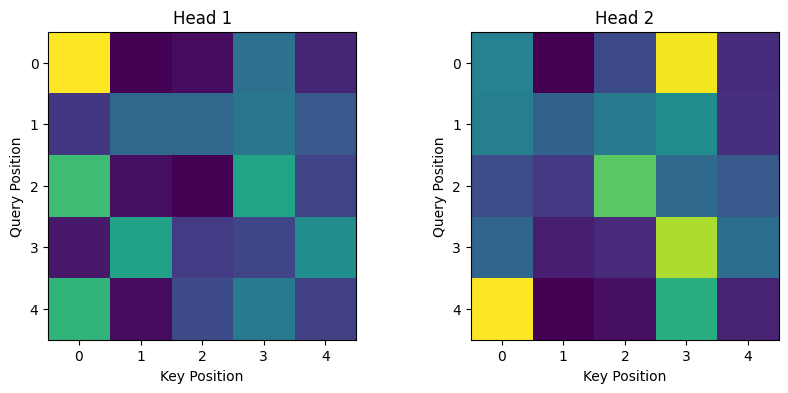

In [2]:
import matplotlib.pyplot as plt

# Sample input
x = jax.random.normal(rng, (1, 5, 64))
output, attn_weights = model.apply(params, x)

# Visualize attention weights for the first two heads
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i in range(2):
    axes[i].imshow(attn_weights[0, i], cmap='viridis')
    axes[i].set_title(f"Head {i+1}")
    axes[i].set_xlabel("Key Position")
    axes[i].set_ylabel("Query Position")
plt.show()

Section 5: Conclusion

### Conclusion
You’ve successfully implemented multi-head attention in Flax! This component is essential for transformers, enabling them to capture multiple aspects of the input. In the next notebook, we’ll use this to build a full transformer block.